# Baseball Savant Pitch Selection Algorithm - Data Prep

Name(s): Connor Vucovich, Doruk Ozar, and Taylor LaMantia

Class: CSCI 349 - Intro to Data Mining  

Section: 11am - 1

Semester: Spring 2024

Instructors: Brian King, Joshua Stough

---

Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier

---
# Problem Description
---

The goal of this project is to develop a machine learning algorithm that can classify the description (outcome) of a baseball pitch based on various features such as pitch speed, spin rate, and movement. The dataset contains information about pitches thrown by various pitchers in Major League Baseball, including the pitch type, release speed, spin rate, and movement of the pitch. By training a machine learning model on this data, we aim to classify the description (outcome) of a given pitch based on its characteristics such as speed, roation, pitch type, spin rate and etc.

---
# Data - Exploration & Preprocessing
---

*What data are you using to understand the problem? Describe the data in a very general sense. 
Where did it come from? You should understand what every observation in the data represents, 
and what each variable represents.*

We are using baseball track man data from Major League Baseball’s official data storage facility. This data contains the outcome of every single pitch thrown in the MLB this past year and the metrics of the pitch as well, such as the velocity of the pitch toward home, the extension the pitcher gets off of the mound toward home upon release, the amount of spin on the ball as it is released by the pitcher, the direction of the spin on the ball as it leaves the pitchers hand, the horizontal movement on the ball as it approaches the batter in feet, the vertical movement on the ball as it approaches the batter in feet, and the effective speed which take the extension the pitcher into account and adjusts the perceived velocity that the batter would see based on this distance reduction. 


Read in baseball dataframe

In [2]:
# Combine parts of a file path for portability across operating systems
path = os.path.join('..', 'data', 'savant_data__2_.csv')
# Read a CSV file into a DataFrame, using the specified path
df_pitches = pd.read_csv(path)
# Set the index of the DataFrame to the 'player_name' column to allow for easier data access by player name
df_pitches.set_index('player_name', inplace=True)

In [3]:
df_pitches.info() # display the data types of each column

<class 'pandas.core.frame.DataFrame'>
Index: 11925 entries, Bello, Brayan to Berríos, José
Data columns (total 91 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pitch_type                       11925 non-null  object 
 1   game_date                        11925 non-null  object 
 2   release_speed                    11925 non-null  float64
 3   release_pos_x                    11925 non-null  float64
 4   release_pos_z                    11925 non-null  float64
 5   batter                           11925 non-null  int64  
 6   pitcher                          11925 non-null  int64  
 7   events                           3015 non-null   object 
 8   description                      11925 non-null  object 
 9   spin_dir                         0 non-null      float64
 10  spin_rate_deprecated             0 non-null      float64
 11  break_angle_deprecated           0 non-null      float64
 12  bre

In [4]:
df_pitches.head(10) # display the first 10 rows of the DataFrame

pitch_type   game_date  release_speed  release_pos_x  \
player_name                                                          
Bello, Brayan         SL  2024-04-14           86.8          -1.79   
Bello, Brayan         CH  2024-04-14           83.3          -1.87   
Bello, Brayan         SI  2024-04-14           96.0          -1.81   
Bello, Brayan         CH  2024-04-14           84.8          -1.99   
Bello, Brayan         SL  2024-04-14           85.5          -1.83   
Bello, Brayan         SI  2024-04-14           95.8          -1.69   
Bello, Brayan         SL  2024-04-14           86.8          -1.55   
Bello, Brayan         CH  2024-04-14           85.6          -1.77   
Berríos, José         SI  2024-04-14           93.7          -1.88   
Bello, Brayan         SI  2024-04-14           95.3          -1.80   

               release_pos_z  batter  pitcher     events      description  \
player_name                                                                 
Bello, Brayan           5.07  543305   678394     single    hit_into_play   
Bello, Brayan           5.05  543305   678394        NaN    called_strike   
Bello, Brayan           4.96  543305   678394        NaN  swinging_strike   
Bello, Brayan           5.08  543305   678394        NaN             ball   
Bello, Brayan           5.13  543305   678394        NaN             ball   
Bello, Brayan           5.02  621493   678394     single    hit_into_play   
Bello, Brayan           5.18  621493   678394        NaN             foul   
Bello, Brayan           4.96  621493   678394        NaN             foul   
Berríos, José           5.62  607732   621244  field_out    hit_into_play   
Bello, Brayan           4.91  621493   678394        NaN             foul   

               spin_dir  ...  fld_score  post_away_score  post_home_score  \
player_name              ...                                                
Bello, Brayan       NaN  ...          3                2                3   
Bello, Brayan       NaN  ...          3                2                3   
Bello, Brayan       NaN  ...          3                2                3   
Bello, Brayan       NaN  ...          3                2                3   
Bello, Brayan       NaN  ...          3                2                3   
Bello, Brayan       NaN  ...          3                2                3   
Bello, Brayan       NaN  ...          3                2                3   
Bello, Brayan       NaN  ...          3                2                3   
Berríos, José       NaN  ...          4                0                4   
Bello, Brayan       NaN  ...          3                2                3   

               post_bat_score post_fld_score if_fielding_alignment  \
player_name                                                          
Bello, Brayan               2              3              Standard   
Bello, Brayan               2              3              Standard   
Bello, Brayan               2              3              Standard   
Bello, Brayan               2              3              Standard   
Bello, Brayan               2              3              Standard   
Bello, Brayan               2              3              Standard   
Bello, Brayan               2              3              Standard   
Bello, Brayan               2              3              Standard   
Berríos, José               0              4              Standard   
Bello, Brayan               2              3              Standard   

              of_fielding_alignment spin_axis delta_home_win_exp delta_run_exp  
player_name                                                                     
Bello, Brayan              Standard      50.0             -0.074         0.793  
Bello, Brayan              Standard     246.0              0.000        -0.098  
Bello, Brayan              Standard     247.0              0.000        -0.091  
Bello, Brayan              Standard     256.0              0.000         0.05

Replace occurences of 'hit_into_play' in the 'description' column with NaN. Fill missing values in the 'description' column with corresponding values from the 'events' column. Drop the 'events' column from the DataFrame.

In [5]:
# Create a copy of the df_pitches DataFrame to clean and manipulate the data without altering the original data
df_pitches_cleaned = df_pitches
# Replace occurrences of 'hit_into_play' in the 'description' column with NaN (not a number) values
df_pitches_cleaned['description'].replace('hit_into_play', np.nan, inplace=True)
# Fill any NaN values in the 'description' column with corresponding values from the 'events' column
df_pitches_cleaned['description'] = df_pitches_cleaned['description'].fillna(df_pitches_cleaned['events'])
# Drop the 'events' column from the DataFrame as it is no longer needed after merging its data into 'description'
df_pitches_cleaned.drop('events', axis=1, inplace=True)
# Display the first 10 rows of the cleaned DataFrame to verify changes and see the cleaned data
df_pitches_cleaned.head(10)


C:\Users\20lam\AppData\Local\Temp\ipykernel_14632\1670979213.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pitches_cleaned['description'].replace('hit_into_play', np.nan, inplace=True)


pitch_type   game_date  release_speed  release_pos_x  \
player_name                                                          
Bello, Brayan         SL  2024-04-14           86.8          -1.79   
Bello, Brayan         CH  2024-04-14           83.3          -1.87   
Bello, Brayan         SI  2024-04-14           96.0          -1.81   
Bello, Brayan         CH  2024-04-14           84.8          -1.99   
Bello, Brayan         SL  2024-04-14           85.5          -1.83   
Bello, Brayan         SI  2024-04-14           95.8          -1.69   
Bello, Brayan         SL  2024-04-14           86.8          -1.55   
Bello, Brayan         CH  2024-04-14           85.6          -1.77   
Berríos, José         SI  2024-04-14           93.7          -1.88   
Bello, Brayan         SI  2024-04-14           95.3          -1.80   

               release_pos_z  batter  pitcher      description  spin_dir  \
player_name                                                                
Bello, Brayan           5.07  543305   678394           single       NaN   
Bello, Brayan           5.05  543305   678394    called_strike       NaN   
Bello, Brayan           4.96  543305   678394  swinging_strike       NaN   
Bello, Brayan           5.08  543305   678394             ball       NaN   
Bello, Brayan           5.13  543305   678394             ball       NaN   
Bello, Brayan           5.02  621493   678394           single       NaN   
Bello, Brayan           5.18  621493   678394             foul       NaN   
Bello, Brayan           4.96  621493   678394             foul       NaN   
Berríos, José           5.62  607732   621244        field_out       NaN   
Bello, Brayan           4.91  621493   678394             foul       NaN   

               spin_rate_deprecated  ...  fld_score  post_away_score  \
player_name                          ...                               
Bello, Brayan                   NaN  ...          3                2   
Bello, Brayan                   NaN  ...          3                2   
Bello, Brayan                   NaN  ...          3                2   
Bello, Brayan                   NaN  ...          3                2   
Bello, Brayan                   NaN  ...          3                2   
Bello, Brayan                   NaN  ...          3                2   
Bello, Brayan                   NaN  ...          3                2   
Bello, Brayan                   NaN  ...          3                2   
Berríos, José                   NaN  ...          4                0   
Bello, Brayan                   NaN  ...          3                2   

               post_home_score post_bat_score post_fld_score  \
player_name                                                    
Bello, Brayan                3              2              3   
Bello, Brayan                3              2              3   
Bello, Brayan                3              2              3   
Bello, Brayan                3              2              3   
Bello, Brayan                3              2              3   
Bello, Brayan                3              2              3   
Bello, Brayan                3              2              3   
Bello, Brayan                3              2              3   
Berríos, José                4              0              4   
Bello, Brayan                3              2              3   

              if_fielding_alignment of_fielding_alignment spin_axis  \
player_name                                                           
Bello, Brayan              Standard              Standard      50.0   
Bello, Brayan              Standard              Standard     246.0   
Bello, Brayan              Standard              Standard     247.0   
Bello, Brayan              Standard              Standard     256.0   
Bello, Brayan              Standard              Standard      27.0   
Bello, Brayan              Standard              Standard     243.0   
Bello, Brayan              Standard              Standard 

In [6]:
# df_pitches_cleaned.set_index('description', inplace=True) # set the index of the DataFrame to the 'description' column to allow for easier data access by description
# df_pitches_cleaned.head(10) # display the first 10 rows of the DataFrame

Rename column names to more descriptive and select specific columns to make df more compact.


In [7]:
# Create a new DataFrame 'df_pitches_compact' by selecting specific columns from 'df_pitches_cleaned'
df_pitches_compact = df_pitches_cleaned[['pitch_type', 'release_speed', 'effective_speed', 'spin_axis', 'release_spin_rate', 'release_extension', 'p_throws', 'pfx_x', 'pfx_z', 'description']]
# Rename the 'release_spin_rate' column to 'spin_rate' for clarity and simplicity
df_pitches_compact = df_pitches_compact.rename(columns={'release_spin_rate': 'spin_rate'})
# Rename the 'p_throws' column to 'pitcher_handedness' to more clearly describe the data it represents
df_pitches_compact = df_pitches_compact.rename(columns={'p_throws': 'pitcher_handedness'})
# Rename the 'pfx_x' column to 'horizontal_movement (ft)' to clarify that it represents the horizontal movement of the pitch in feet
df_pitches_compact = df_pitches_compact.rename(columns={'pfx_x': 'horizontal_movement (ft)'})
# Rename the 'pfx_z' column to 'vertical_movement (ft)' to clarify that it represents the vertical movement of the pitch in feet
df_pitches_compact = df_pitches_compact.rename(columns={'pfx_z': 'vertical_movement (ft)'})
# Display the first few rows of the updated DataFrame to check the new structure and the changes made
df_pitches_compact.head(10)

pitch_type  release_speed  effective_speed  spin_axis  \
player_name                                                           
Bello, Brayan         SL           86.8             87.9       50.0   
Bello, Brayan         CH           83.3             84.7      246.0   
Bello, Brayan         SI           96.0             96.8      247.0   
Bello, Brayan         CH           84.8             85.6      256.0   
Bello, Brayan         SL           85.5             86.4       27.0   
Bello, Brayan         SI           95.8             97.0      243.0   
Bello, Brayan         SL           86.8             87.3       56.0   
Bello, Brayan         CH           85.6             86.4      251.0   
Berríos, José         SI           93.7             93.9      223.0   
Bello, Brayan         SI           95.3             96.4      247.0   

               spin_rate  release_extension pitcher_handedness  \
player_name                                                      
Bello, Brayan     2437.0                6.4                  R   
Bello, Brayan     1737.0                6.8                  R   
Bello, Brayan     1992.0                6.7                  R   
Bello, Brayan     1650.0                6.7                  R   
Bello, Brayan     2366.0                6.8                  R   
Bello, Brayan     2023.0                6.7                  R   
Bello, Brayan     2298.0                6.2                  R   
Bello, Brayan     1533.0                6.5                  R   
Berríos, José     1855.0                6.6                  R   
Bello, Brayan     1919.0                6.7                  R   

               horizontal_movement (ft)  vertical_movement (ft)  \
player_name                                                       
Bello, Brayan                      0.33                    0.20   
Bello, Brayan                     -1.32                    0.36   
Bello, Brayan                     -1.43                   -0.11   
Bello, Brayan                     -1.34                    0.29   
Bello, Brayan                      0.38                    0.29   
Bello, Brayan                     -1.41                    0.17   
Bello, Brayan                      0.51                    0.08   
Bello, Brayan                     -1.40                    0.00   
Berríos, José                     -1.37                    0.80   
Bello, Brayan                     -1.45                   -0.04   

                   description  
player_name                     
Bello, Brayan           single  
Bello, Brayan    called_strike  
Bello, Brayan  swinging_strike  
Bello, Brayan             ball  
Bello, Brayan             ball  
Bello, Brayan           single  
Bello, Brayan             foul  
Bello, Brayan             foul  
Berríos, José        field_out  
Bello, Brayan             foul

*You should strive to generate good summary statistics, show what the data looks like, and 
include good EDA and visualizations with boxplots, barcharts, density plots for key variables, or 
whatever other plots you want that are specific to your data and problem to help the reader
understand basic distributions of important variables. Remember - visualizations can help you 
convey general info about your data and are extremely helpful*

View datatypes and number of null per column

In [8]:
df_pitches_compact.info() # display the data types of each column

<class 'pandas.core.frame.DataFrame'>
Index: 11925 entries, Bello, Brayan to Berríos, José
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pitch_type                11925 non-null  object 
 1   release_speed             11925 non-null  float64
 2   effective_speed           11925 non-null  float64
 3   spin_axis                 11606 non-null  float64
 4   spin_rate                 11606 non-null  float64
 5   release_extension         11916 non-null  float64
 6   pitcher_handedness        11925 non-null  object 
 7   horizontal_movement (ft)  11925 non-null  float64
 8   vertical_movement (ft)    11925 non-null  float64
 9   description               11925 non-null  object 
dtypes: float64(7), object(3)
memory usage: 1.0+ MB


Convert pitch_type, pitcher_handedness, and description to categorical. Downcast all floats.

In [9]:
# convert necessary columns to categorical
df_pitches_compact['pitch_type'] = pd.Categorical(df_pitches_compact['pitch_type'])
df_pitches_compact['pitcher_handedness'] = pd.Categorical(df_pitches_compact['pitcher_handedness'])
df_pitches_compact['description'] = pd.Categorical(df_pitches_compact['description'])

# Convert all numeric variables to simplest numeric types
df_float_downcast = df_pitches_compact.select_dtypes('float').columns
df_pitches_compact[df_float_downcast]=df_pitches_compact[df_float_downcast].apply(pd.to_numeric, downcast='float')

# check types and sizes of columns after adjustments
df_pitches_compact.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11925 entries, Bello, Brayan to Berríos, José
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   pitch_type                11925 non-null  category
 1   release_speed             11925 non-null  float32 
 2   effective_speed           11925 non-null  float32 
 3   spin_axis                 11606 non-null  float32 
 4   spin_rate                 11606 non-null  float32 
 5   release_extension         11916 non-null  float32 
 6   pitcher_handedness        11925 non-null  category
 7   horizontal_movement (ft)  11925 non-null  float32 
 8   vertical_movement (ft)    11925 non-null  float32 
 9   description               11925 non-null  category
dtypes: category(3), float32(7)
memory usage: 455.7+ KB


We have a few null values in spin_axis, spin_rate, and release_extension. These will be removed

In [10]:
df_pitches_compact.describe().T # display summary statistics for each column in the DataFrame

count         mean         std        min  \
release_speed             11925.0    88.444176    6.055729  35.099998   
effective_speed           11925.0    88.506165    6.681718   0.000000   
spin_axis                 11606.0   172.582108   73.588303   0.000000   
spin_rate                 11606.0  2300.188477  347.700592  28.000000   
release_extension         11916.0     6.449790    0.468519   3.500000   
horizontal_movement (ft)  11925.0    -0.146462    0.943972  -2.950000   
vertical_movement (ft)    11925.0     0.575260    0.753127  -1.960000   

                                  25%          50%          75%          max  
release_speed               84.300003    89.000000    93.500000   102.300003  
effective_speed             84.599998    89.199997    93.599998   103.699997  
spin_axis                  131.000000   196.000000   222.000000   359.000000  
spin_rate                 2143.000000  2326.000000  2490.000000  3446.000000  
release_extension            6.100000     6.400000     6.700000     8.100000  
horizontal_movement (ft)    -0.980000    -0.160000     0.580000     2.040000  
vertical_movement (ft)       0.110000     0.570000     1.220000     2.310000

spin_axis and spin_rate how the most variability from the mean, while the values in release_extension, horizontal_movement, and vertical_movement do not differ at such high extremes.

In [11]:
df_pitches_compact['description'].unique() # display the unique values in the 'description' column

['single', 'called_strike', 'swinging_strike', 'ball', 'foul', ..., 'fielders_choice', 'foul_bunt', 'double_play', 'sac_bunt', 'pitchout']
Length: 24
Categories (24, object): ['ball', 'blocked_ball', 'called_strike', 'double', ..., 'single', 'swinging_strike', 'swinging_strike_blocked', 'triple']

There are 24 unique values in the 'description' column. This will be how many neurons there are in the final layer of the neural net.

View frequency of target variable

In [12]:
 # display the frequency of each unique value in
 # the 'description' column which is our target variable
df_pitches_compact['description'].value_counts()

description
ball                         3992
foul                         2150
called_strike                2061
swinging_strike              1201
field_out                    1183
single                        427
blocked_ball                  261
foul_tip                      142
double                        112
home_run                       98
force_out                      65
grounded_into_double_play      54
swinging_strike_blocked        51
hit_by_pitch                   29
foul_bunt                      21
field_error                    20
sac_fly                        18
fielders_choice                11
triple                         10
fielders_choice_out             8
double_play                     6
missed_bunt                     2
sac_bunt                        2
pitchout                        1
Name: count, dtype: int64

ball, foul, called_strike, swinging_strike, and field_out are the most frequent descriptions with all of them having >1000 occurrences. triple, fielders_choice_out, double_play, missed_bunt, sac_bunt, and pitchout all have <= 20 occurences.

In [13]:
df_pitches_compact.isna().sum() # display the number of missing values in each column of the DataFrame

pitch_type                    0
release_speed                 0
effective_speed               0
spin_axis                   319
spin_rate                   319
release_extension             9
pitcher_handedness            0
horizontal_movement (ft)      0
vertical_movement (ft)        0
description                   0
dtype: int64

Drop null rows

In [14]:
df_pitches_compact.dropna(inplace=True) # drop any rows with missing values from the DataFrame
df_pitches_description = df_pitches_compact
df_pitches_compact.isna().sum() # verify that there are no longer any missing values in the DataFrame

pitch_type                  0
release_speed               0
effective_speed             0
spin_axis                   0
spin_rate                   0
release_extension           0
pitcher_handedness          0
horizontal_movement (ft)    0
vertical_movement (ft)      0
description                 0
dtype: int64

Check that removing nulls does not change distribution of target variable

In [15]:
 # display the frequency of each unique value in
 # the 'description' column which is our target variable
df_pitches_compact['description'].value_counts()

description
ball                         3872
foul                         2092
called_strike                2011
swinging_strike              1164
field_out                    1151
single                        419
blocked_ball                  254
foul_tip                      142
double                        108
home_run                       94
force_out                      65
grounded_into_double_play      51
swinging_strike_blocked        49
hit_by_pitch                   28
foul_bunt                      21
field_error                    20
sac_fly                        18
fielders_choice                11
triple                         10
fielders_choice_out             8
double_play                     6
missed_bunt                     2
sac_bunt                        2
pitchout                        1
Name: count, dtype: int64

---

# Visualizations
Plot boxplots, barcharts, and density plots

Generate bar charts to show distribution of values in each of the 9 predictor variables.

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: F

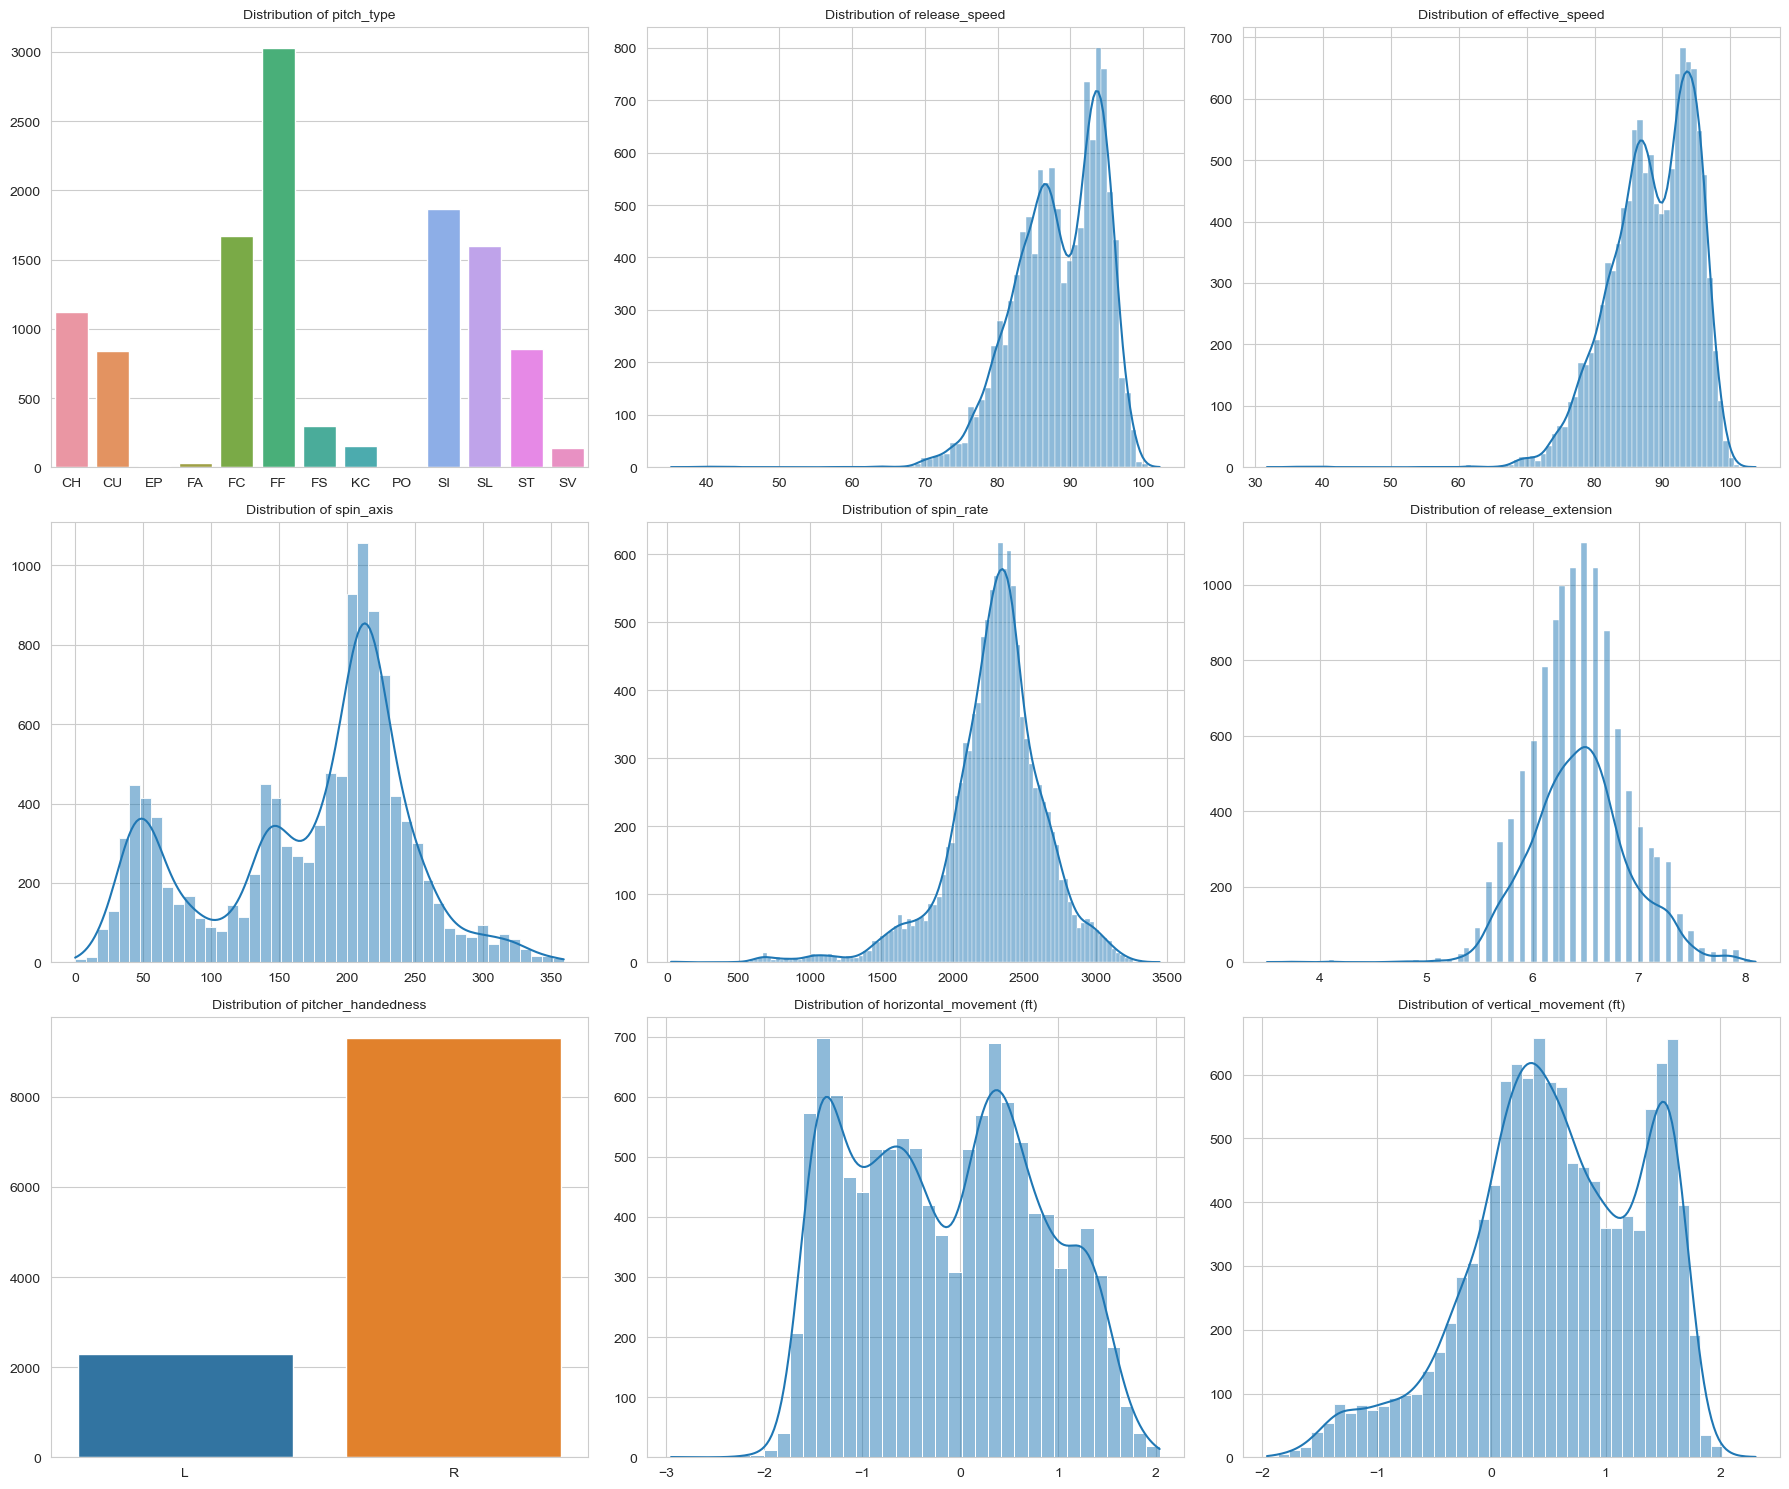

In [16]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the visualizations
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

# List of all columns to plot
all_columns = ['pitch_type', 'release_speed', 'effective_speed', 'spin_axis', 'spin_rate', 'release_extension', 
               'pitcher_handedness', 'horizontal_movement (ft)', 'vertical_movement (ft)', 'description']

numeric_columns = ['release_speed', 'effective_speed', 'spin_axis', 'spin_rate', 'release_extension', 
               'horizontal_movement (ft)', 'vertical_movement (ft)']
# Plot histograms for numeric columns and count plots for categorical columns
for ax, column in zip(axes.flatten(), all_columns):
    if column in numeric_columns:  # Plot histogram for numeric columns
        sns.histplot(df_pitches_compact[column], kde=True, ax=ax)
    else:  # Plot count plot for categorical columns
        sns.countplot(data=df_pitches_compact, x=column, ax=ax)
    ax.set_title(f'Distribution of {column}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Tight layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


release_speed, effective_speed, spin_rate, and vertical_movement are all skewed right. horizontal_movement is bimodal. While release_extension is somewhere in between normal and right-skewed and spin-axis is multimodal. Right-handed pitches are far more common than left-handed. FF, SI, SL, and FC are the most common pitches while EP, FA, and PO are least common.

Plot the count of each target variable class

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


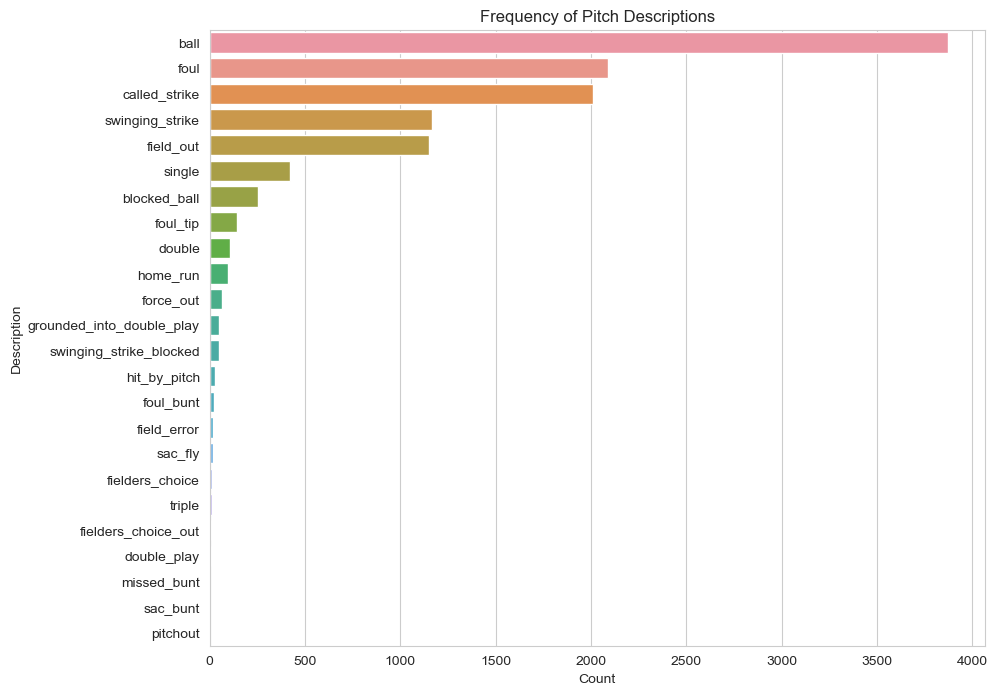

In [17]:
# Plot the count of the target variable 'description'
plt.figure(figsize=(10, 8))
sns.countplot(y='description', data=df_pitches_compact, order=df_pitches_compact['description'].value_counts().index)
plt.title('Frequency of Pitch Descriptions')
plt.xlabel('Count')
plt.ylabel('Description')
plt.show()

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\20lam\anaconda3\envs\csci349\lib\site

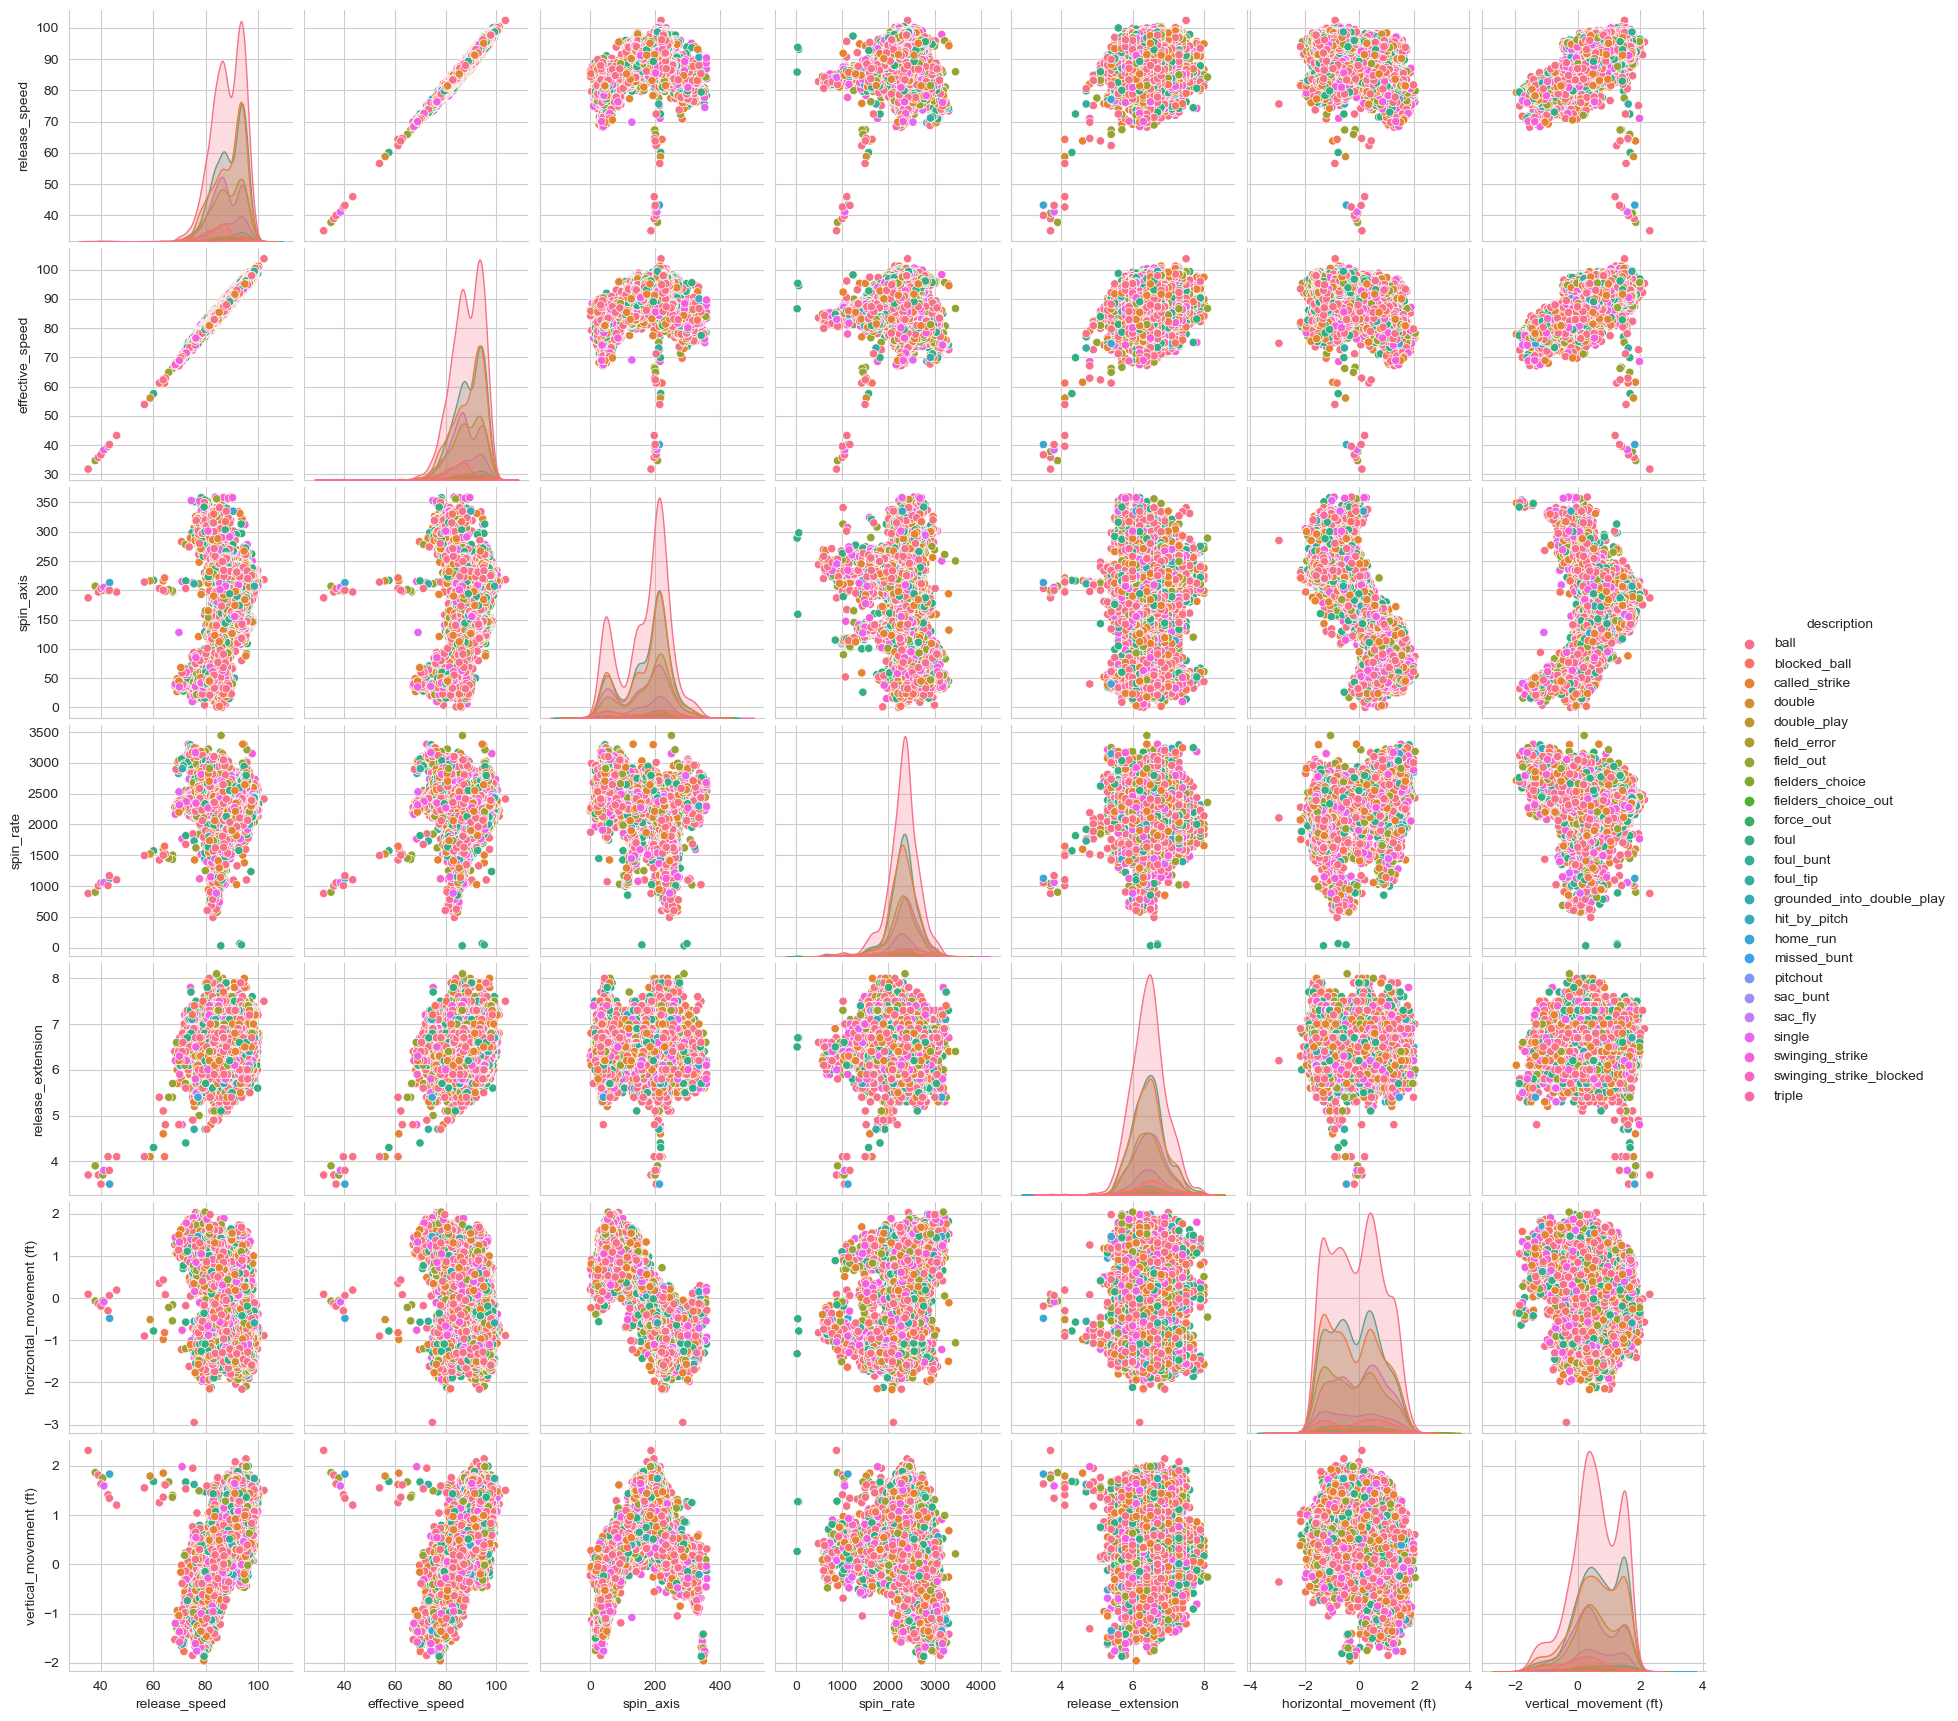

In [18]:
# Pairplot of the DataFrame to visualize the relationships between all pairs of variables
sns.pairplot(df_pitches_compact, hue='description')
plt.show()

This shows that the only linear relation here occurs between release_speed and effective_speed, with there being no outliers. This implies that both of these is not necessary.

Create a pairplot with only the most common 'positive defensive' outcomes of strikes

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\20lam\anaconda3\envs\csci349\lib\site

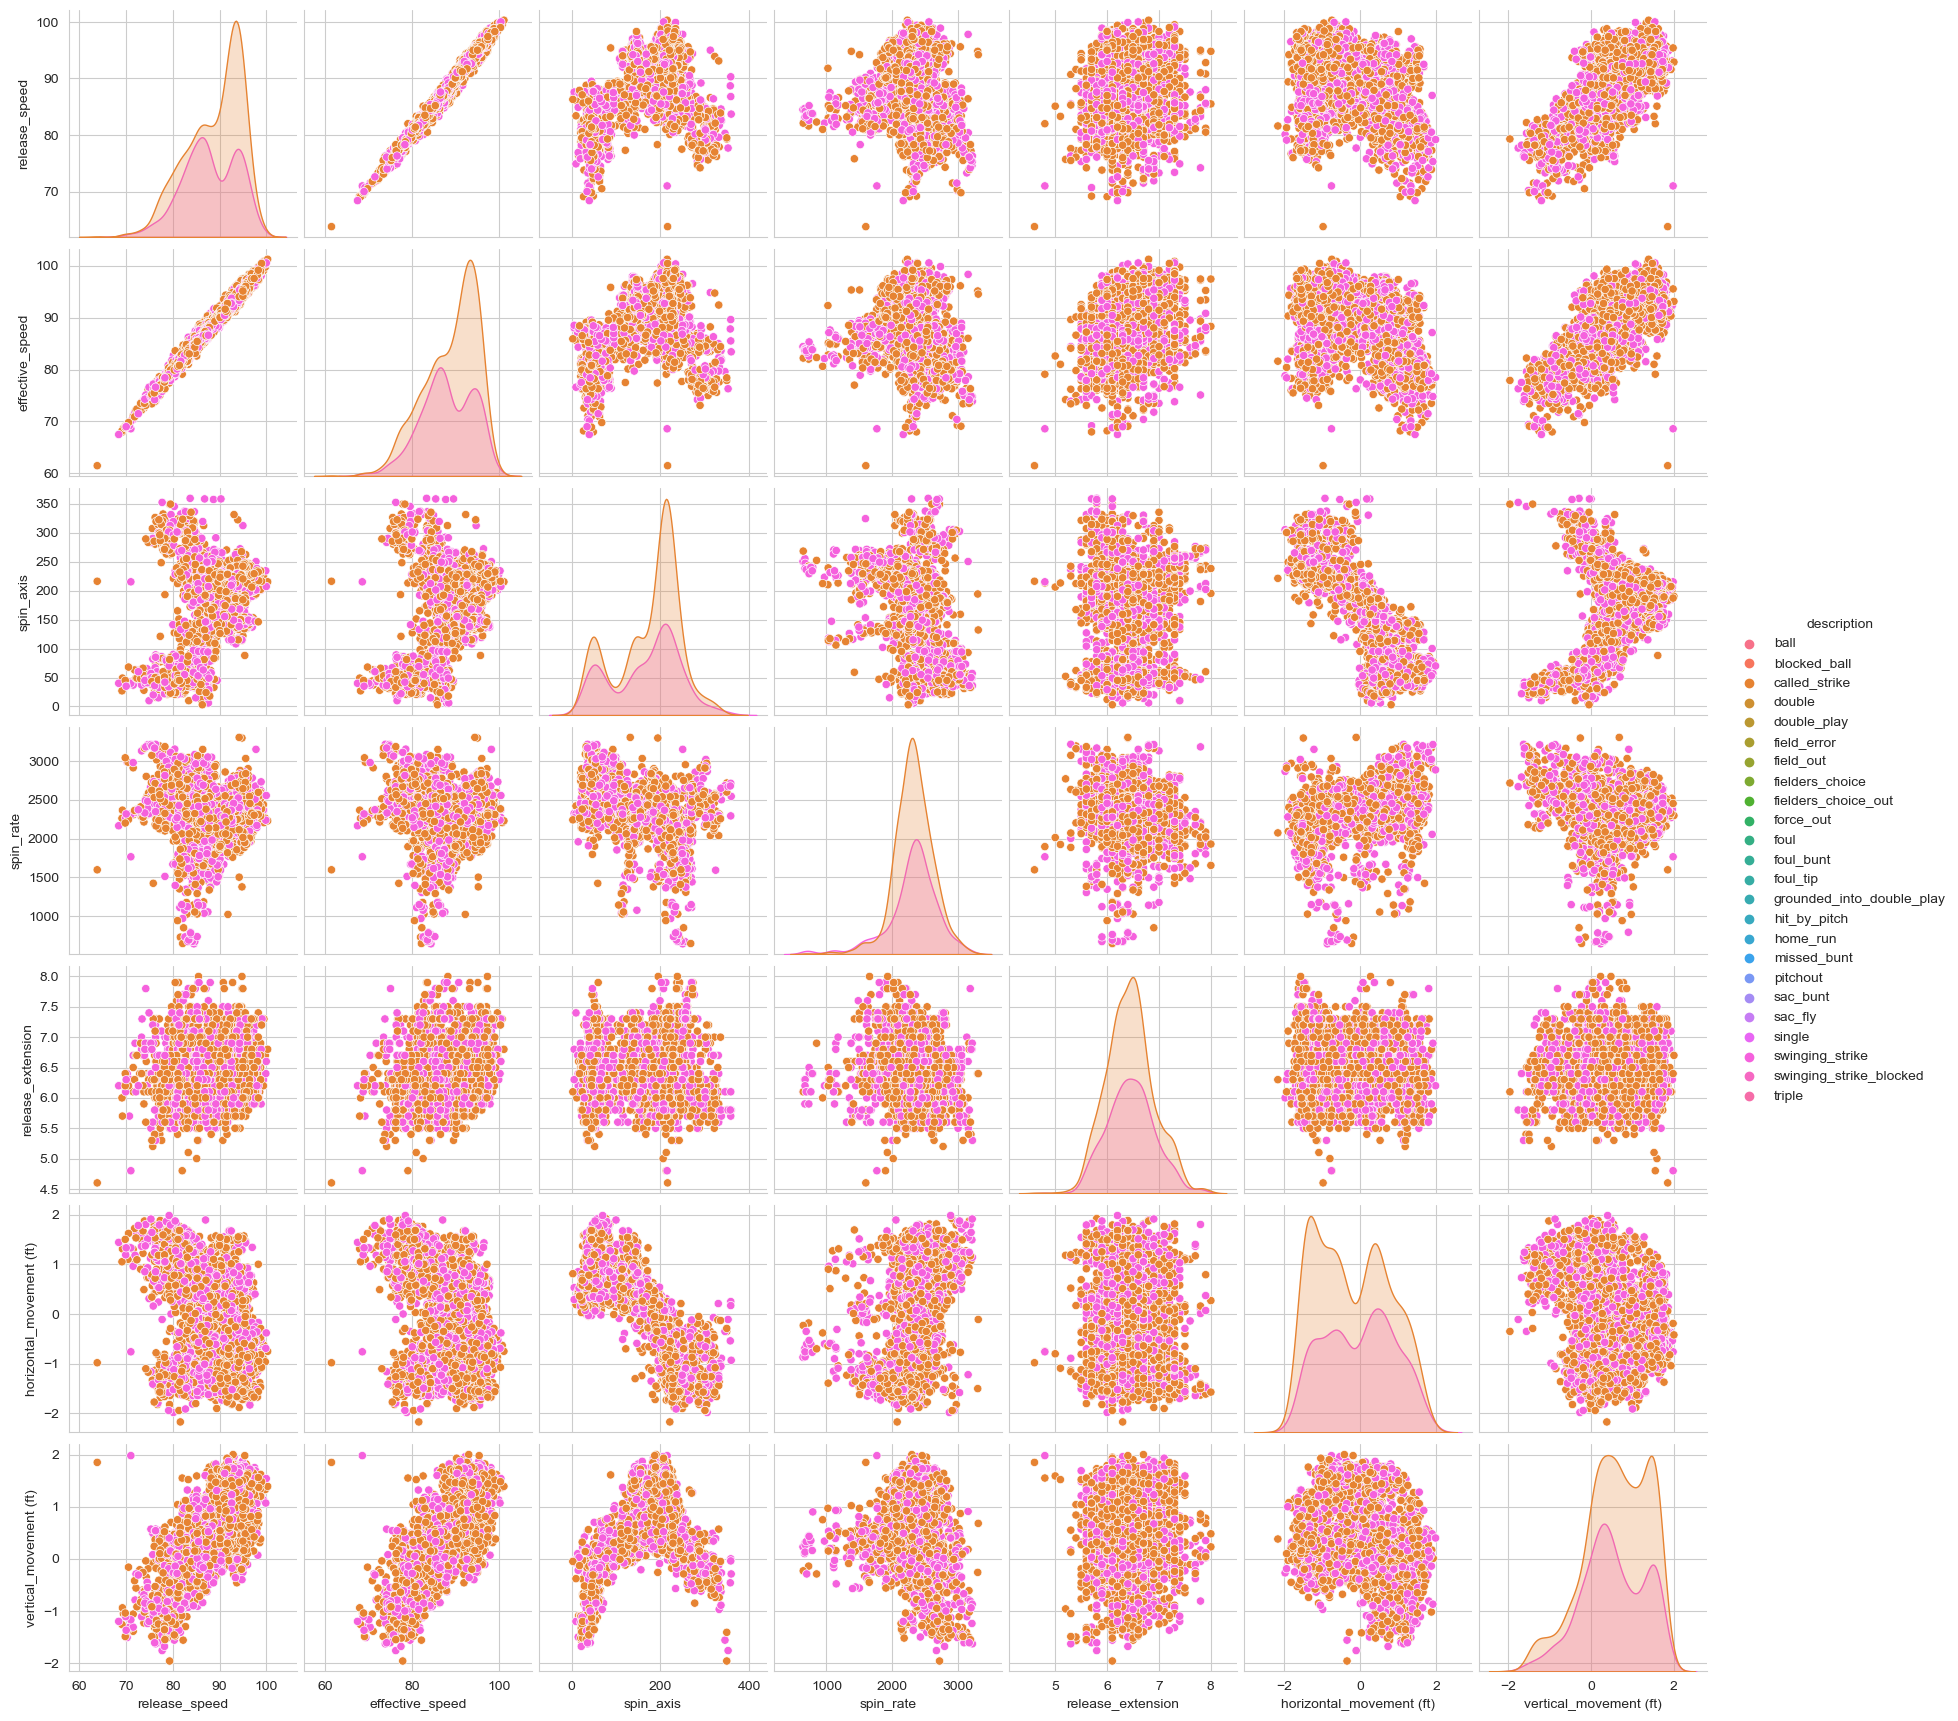

In [19]:
# Filter DataFrame to include only specific values of 'description'
selected_descriptions = ['called_strike', 'swinging_strike']
filtered_df = df_pitches_compact[df_pitches_compact['description'].isin(selected_descriptions)]

# Pairplot of the filtered DataFrame
sns.pairplot(filtered_df, hue='description')
plt.show()

Now show the pairplots of only the pitches that result in hits on base - single, double, triple, home run

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\20lam\anaconda3\envs\csci349\lib\site

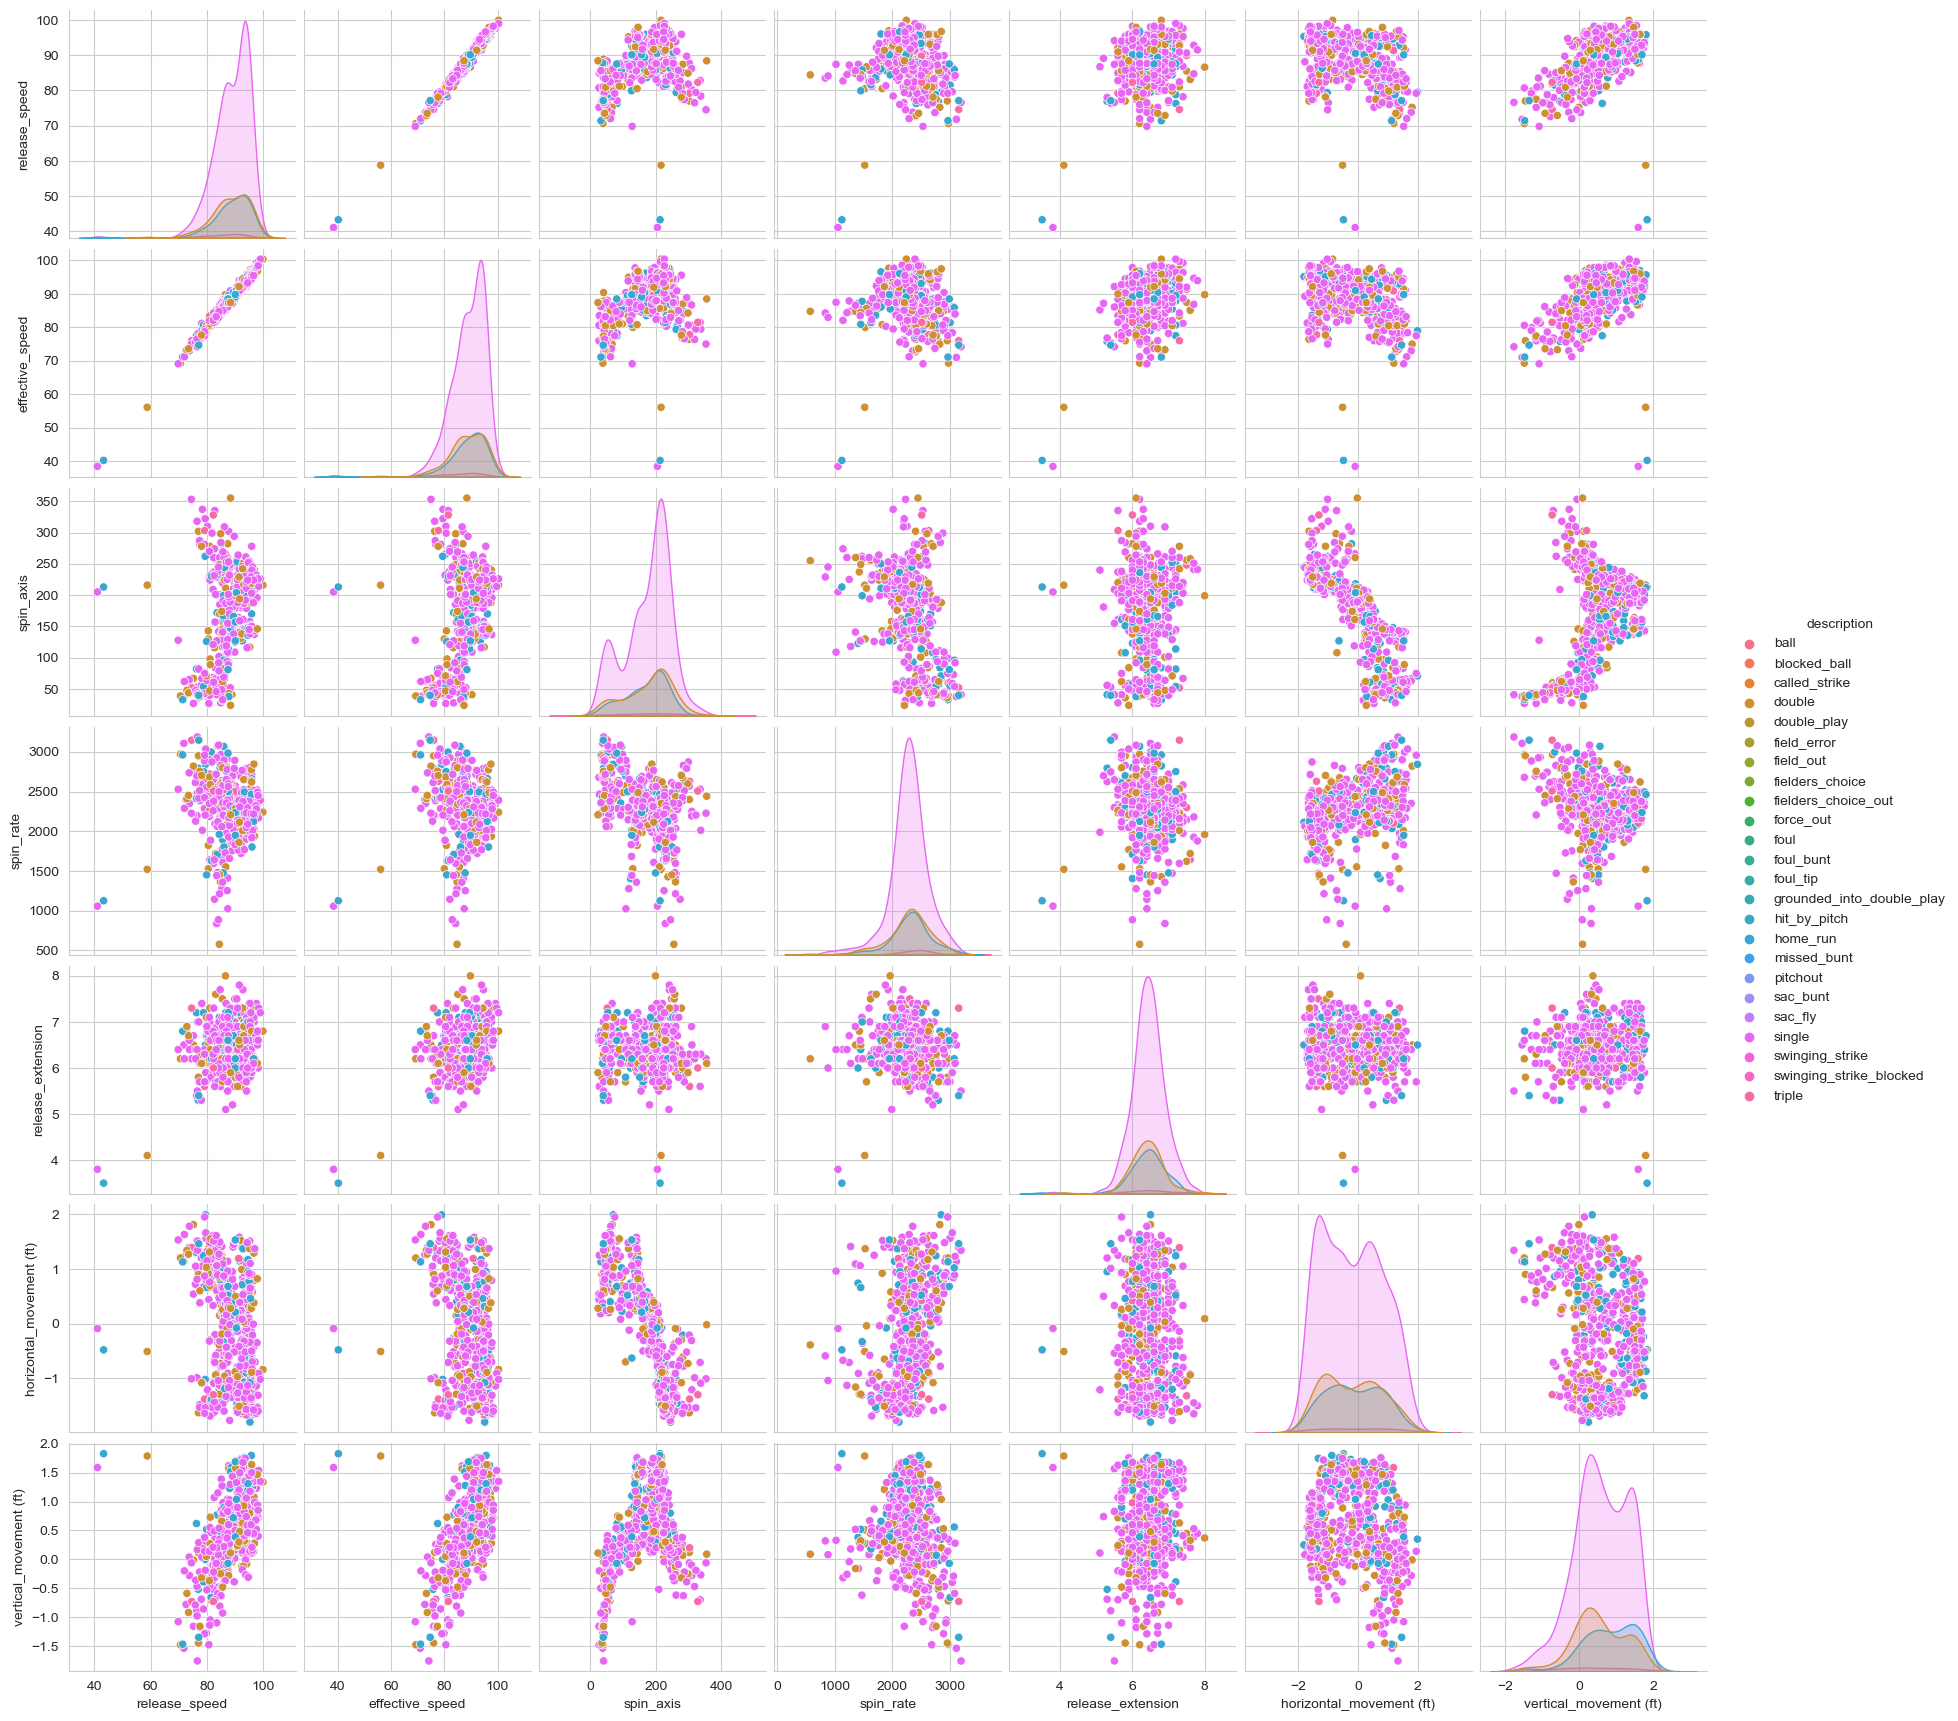

In [20]:
# Filter DataFrame to include only specific values of 'description'
selected_descriptions2 = ['single', 'double', 'triple', 'home_run']
filtered_df2 = df_pitches_compact[df_pitches_compact['description'].isin(selected_descriptions2)]

# Pairplot of the filtered DataFrame
sns.pairplot(filtered_df2, hue='description')
plt.show()

Show boxplots for the numeric features against the target variable

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

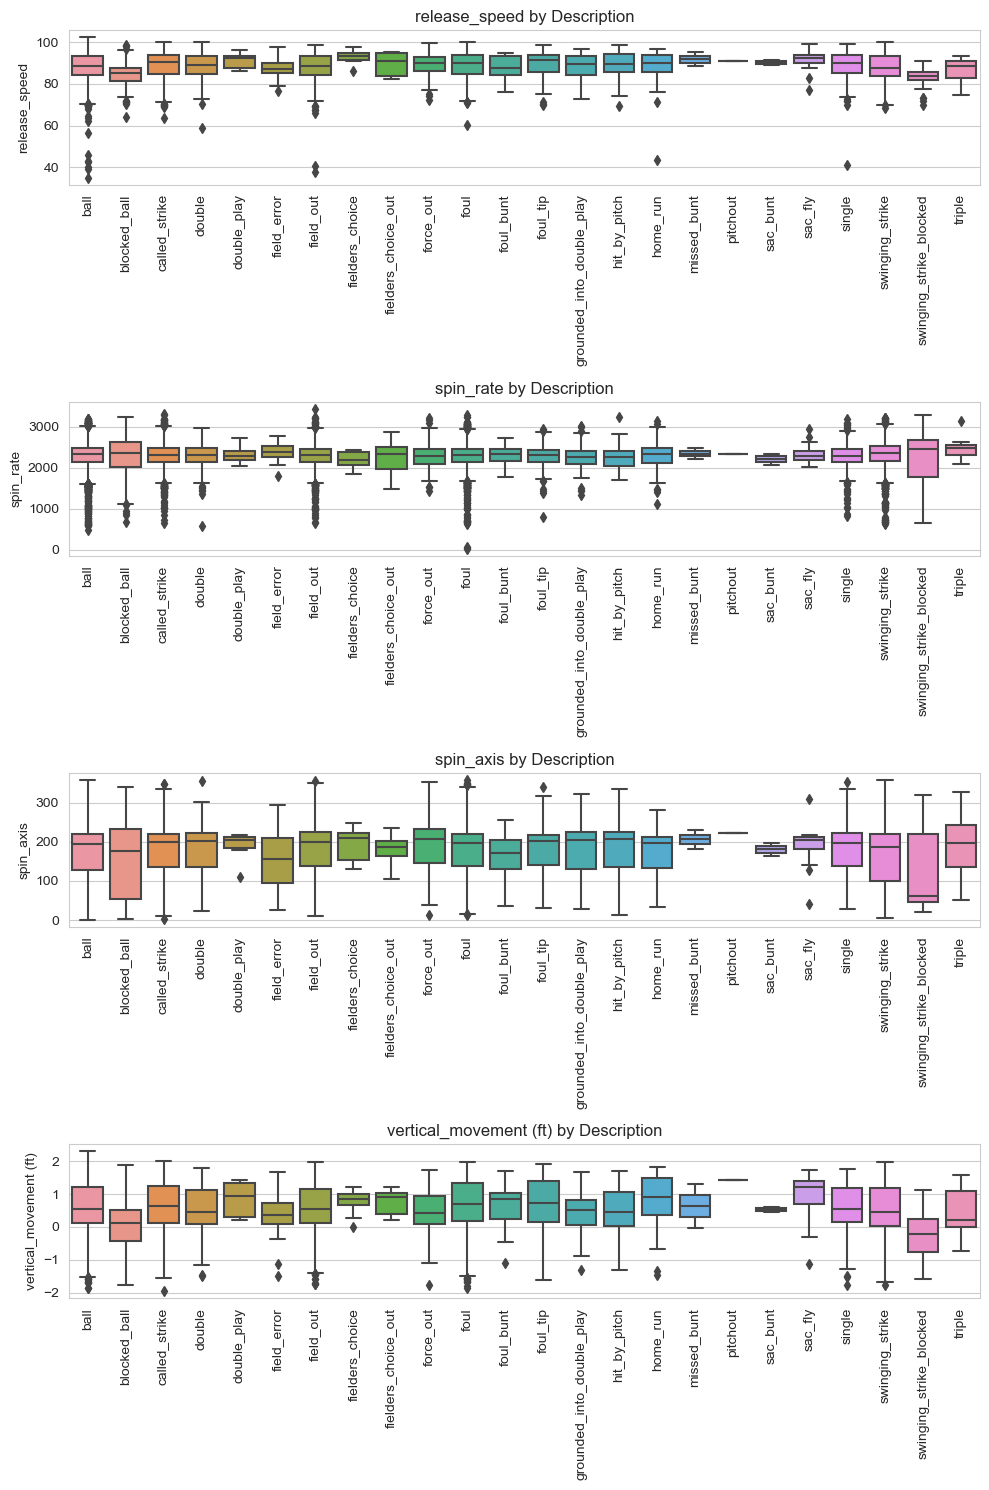

In [21]:
# Create box plots for a few selected numeric features against the target variable 'description'
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# Selected features for detailed examination against the target variable
selected_features = ['release_speed', 'spin_rate', 'spin_axis', 'vertical_movement (ft)']

for ax, feature in zip(axes, selected_features):
    sns.boxplot(x='description', y=feature, data=df_pitches_compact, ax=ax)
    ax.set_title(f'{feature} by Description')
    ax.set_xlabel('')
    ax.set_ylabel(f'{feature}')
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

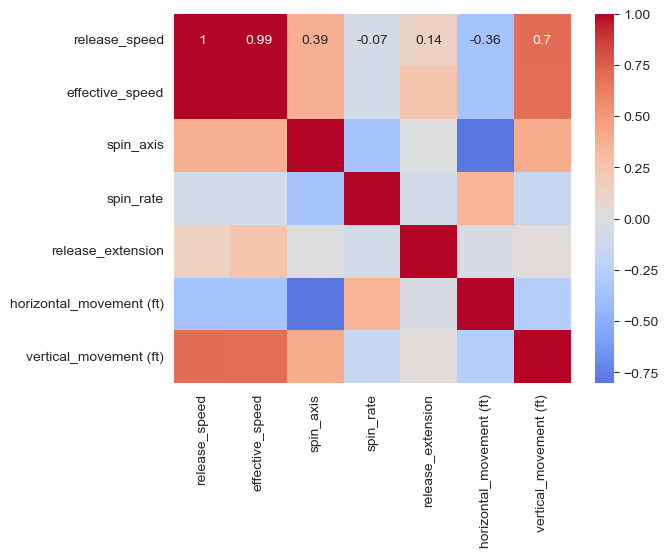

In [22]:
# Create a heatmap of the correlation matrix to visualize the relationships between all pairs of variables
sns.heatmap(df_pitches_compact.select_dtypes(include='float').corr(), annot=True, cmap='coolwarm', center=0) # create a heatmap of the correlation matrix
plt.show()

When looking at the target variable we found that there were a large number of outcomes for the target variable; however these outcomes boiled down to four main true outcomes. There were many different types of balls that were tracked, but each of these types of balls have had the same game outcome. The same was true of strikes, which come in large large variety from called strikes to swinging strikes to foul balls. All of these outcomes have the same effect on the game so we grouped them together. Similarly, for field outs it does not matter the way in which the out is recorded the outcome is all the same, so we grouped them together. Finally, we decided to group hits together, since although they have a slightly different effect on the pitcher, they represent the same effect as the pitcher has allowed a base runner and failed to record an out, so we decided to group them together. The groupings we choose are listed below. 
Categories:

Balls: ball, blocked_ball, hit_by_pitch, pitchout

Strikes: called_strike, swinging_strike, foul, foul_tip, missed_bunt, swinging_strike_blocked, foul_bunt 

Hits: single, double, triple, home_run

Field Outs: sac_bunt, fielders_choice_out, fielders_choice, sac_fly, field_error, force_out, field_out

In [23]:
# Group hits
if 'hit' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('hit')
# Group field_out
if 'field_out' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('field_out')
# Group strike
if 'strike' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('strike')
# Group ball
if 'ball' not in df_pitches_description['description'].cat.categories:
    df_pitches_description['description'] = df_pitches_description['description'].cat.add_categories('ball')
for index, row in df_pitches_description.iterrows():
    if row['description'] == 'ball' or row['description'] == 'blocked_ball' or row['description'] == 'hit_by_pitch' or row['description'] == 'pitchout':
        df_pitches_description.at[index, 'description'] = 'ball'
    elif row['description'] == 'called_strike' or row['description'] == 'swinging_strike' or row['description'] == 'foul' or row['description'] == 'foul_tip' or row['description'] == 'missed_bunt' or row['description'] == 'swinging_strike_blocked' or row['description'] == 'foul_bunt':
        df_pitches_description.at[index, 'description'] = 'strike'
    elif row['description'] == 'single' or row['description'] == 'double' or row['description'] == 'triple' or row['description'] == 'home_run':
        df_pitches_description.at[index, 'description'] = 'hit'
    else:
        df_pitches_description.at[index, 'description'] = 'field_out'
df_pitches_description['description'].value_counts()

description
strike                       6302
ball                         4362
field_out                     619
hit                           316
called_strike                   0
home_run                        0
triple                          0
swinging_strike_blocked         0
swinging_strike                 0
single                          0
sac_fly                         0
sac_bunt                        0
pitchout                        0
missed_bunt                     0
hit_by_pitch                    0
double                          0
blocked_ball                    0
foul_tip                        0
foul_bunt                       0
foul                            0
force_out                       0
fielders_choice_out             0
fielders_choice                 0
field_error                     0
double_play                     0
grounded_into_double_play       0
Name: count, dtype: int64

As you can see above, the most outliers are in the Ball, Called Strike, and Foul. This makes sense because these are the most common outcomes in this dataset and they have the most data points. Hence, it is normal to see more outliers in these categories.

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

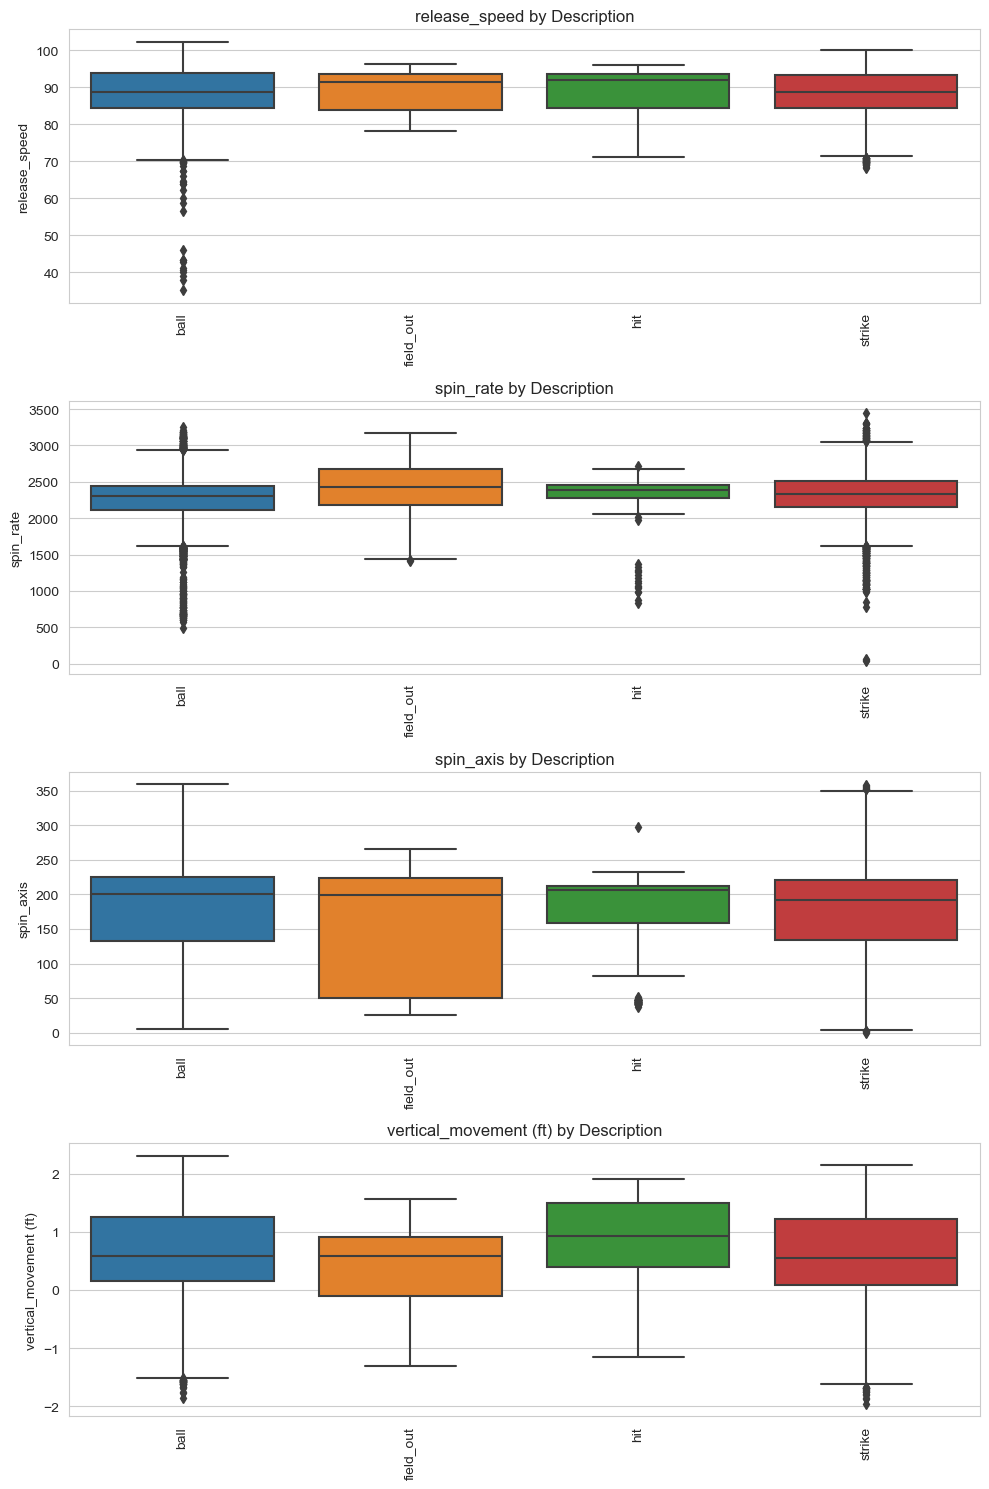

In [24]:
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['blocked_ball'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['called_strike'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['double'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['double_play'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['field_error'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['fielders_choice'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['fielders_choice_out'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['force_out'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['foul'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['foul_bunt'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['foul_tip'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['grounded_into_double_play'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['hit_by_pitch'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['home_run'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['missed_bunt'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['pitchout'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['sac_bunt'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['sac_fly'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['single'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['swinging_strike'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['swinging_strike_blocked'])
df_pitches_description['description'] = df_pitches_description['description'].cat.remove_categories(['triple'])
# Create box plots for a few selected numeric features against the target variable 'description'
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# Selected features for detailed examination against the target variable
selected_features = ['release_speed', 'spin_rate', 'spin_axis', 'vertical_movement (ft)']

for ax, feature in zip(axes, selected_features):
    sns.boxplot(x='description', y=feature, data=df_pitches_description, ax=ax)
    ax.set_title(f'{feature} by Description')
    ax.set_xlabel('')
    ax.set_ylabel(f'{feature}')
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


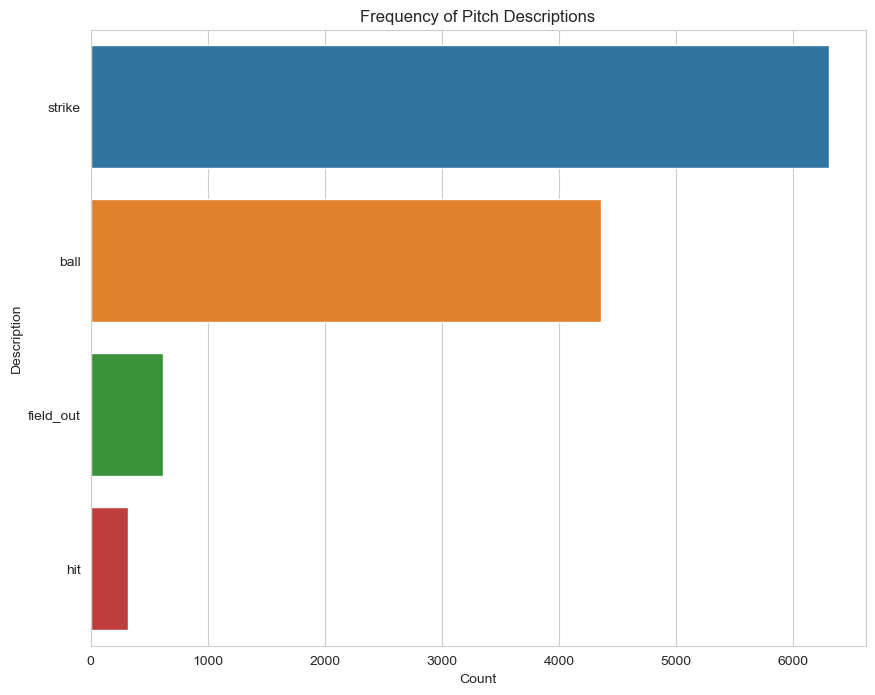

In [25]:
plt.figure(figsize=(10, 8))
sns.countplot(y='description', data=df_pitches_description, order=df_pitches_description['description'].value_counts().index)
plt.title('Frequency of Pitch Descriptions')
plt.xlabel('Count')
plt.ylabel('Description')
plt.show()

As you can see above, the most outliers are in the Ball and Strike. This makes sense because these are the most common outcomes in this dataset and they have the most data points. Hence, it is normal to see more outliers in these categories. In general, the average velocities of a pitch does not seem to have much effect on the outcomes, although pitches of higher spin rates tend to represent a larger amount of the recorded field outs. Similarly, pitches with lower spin axes tend to represent a larger portion of the field outs when compared to other outcomes. Balls and hits also tend to have more veritcal movmement on average than field_outs and strikes, although for ball and strike in every category it seems that there whisters entails the entirety of the range. 

c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\20lam\anaconda3\envs\csci349\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\20lam\anaconda3\envs\csci349\lib\site

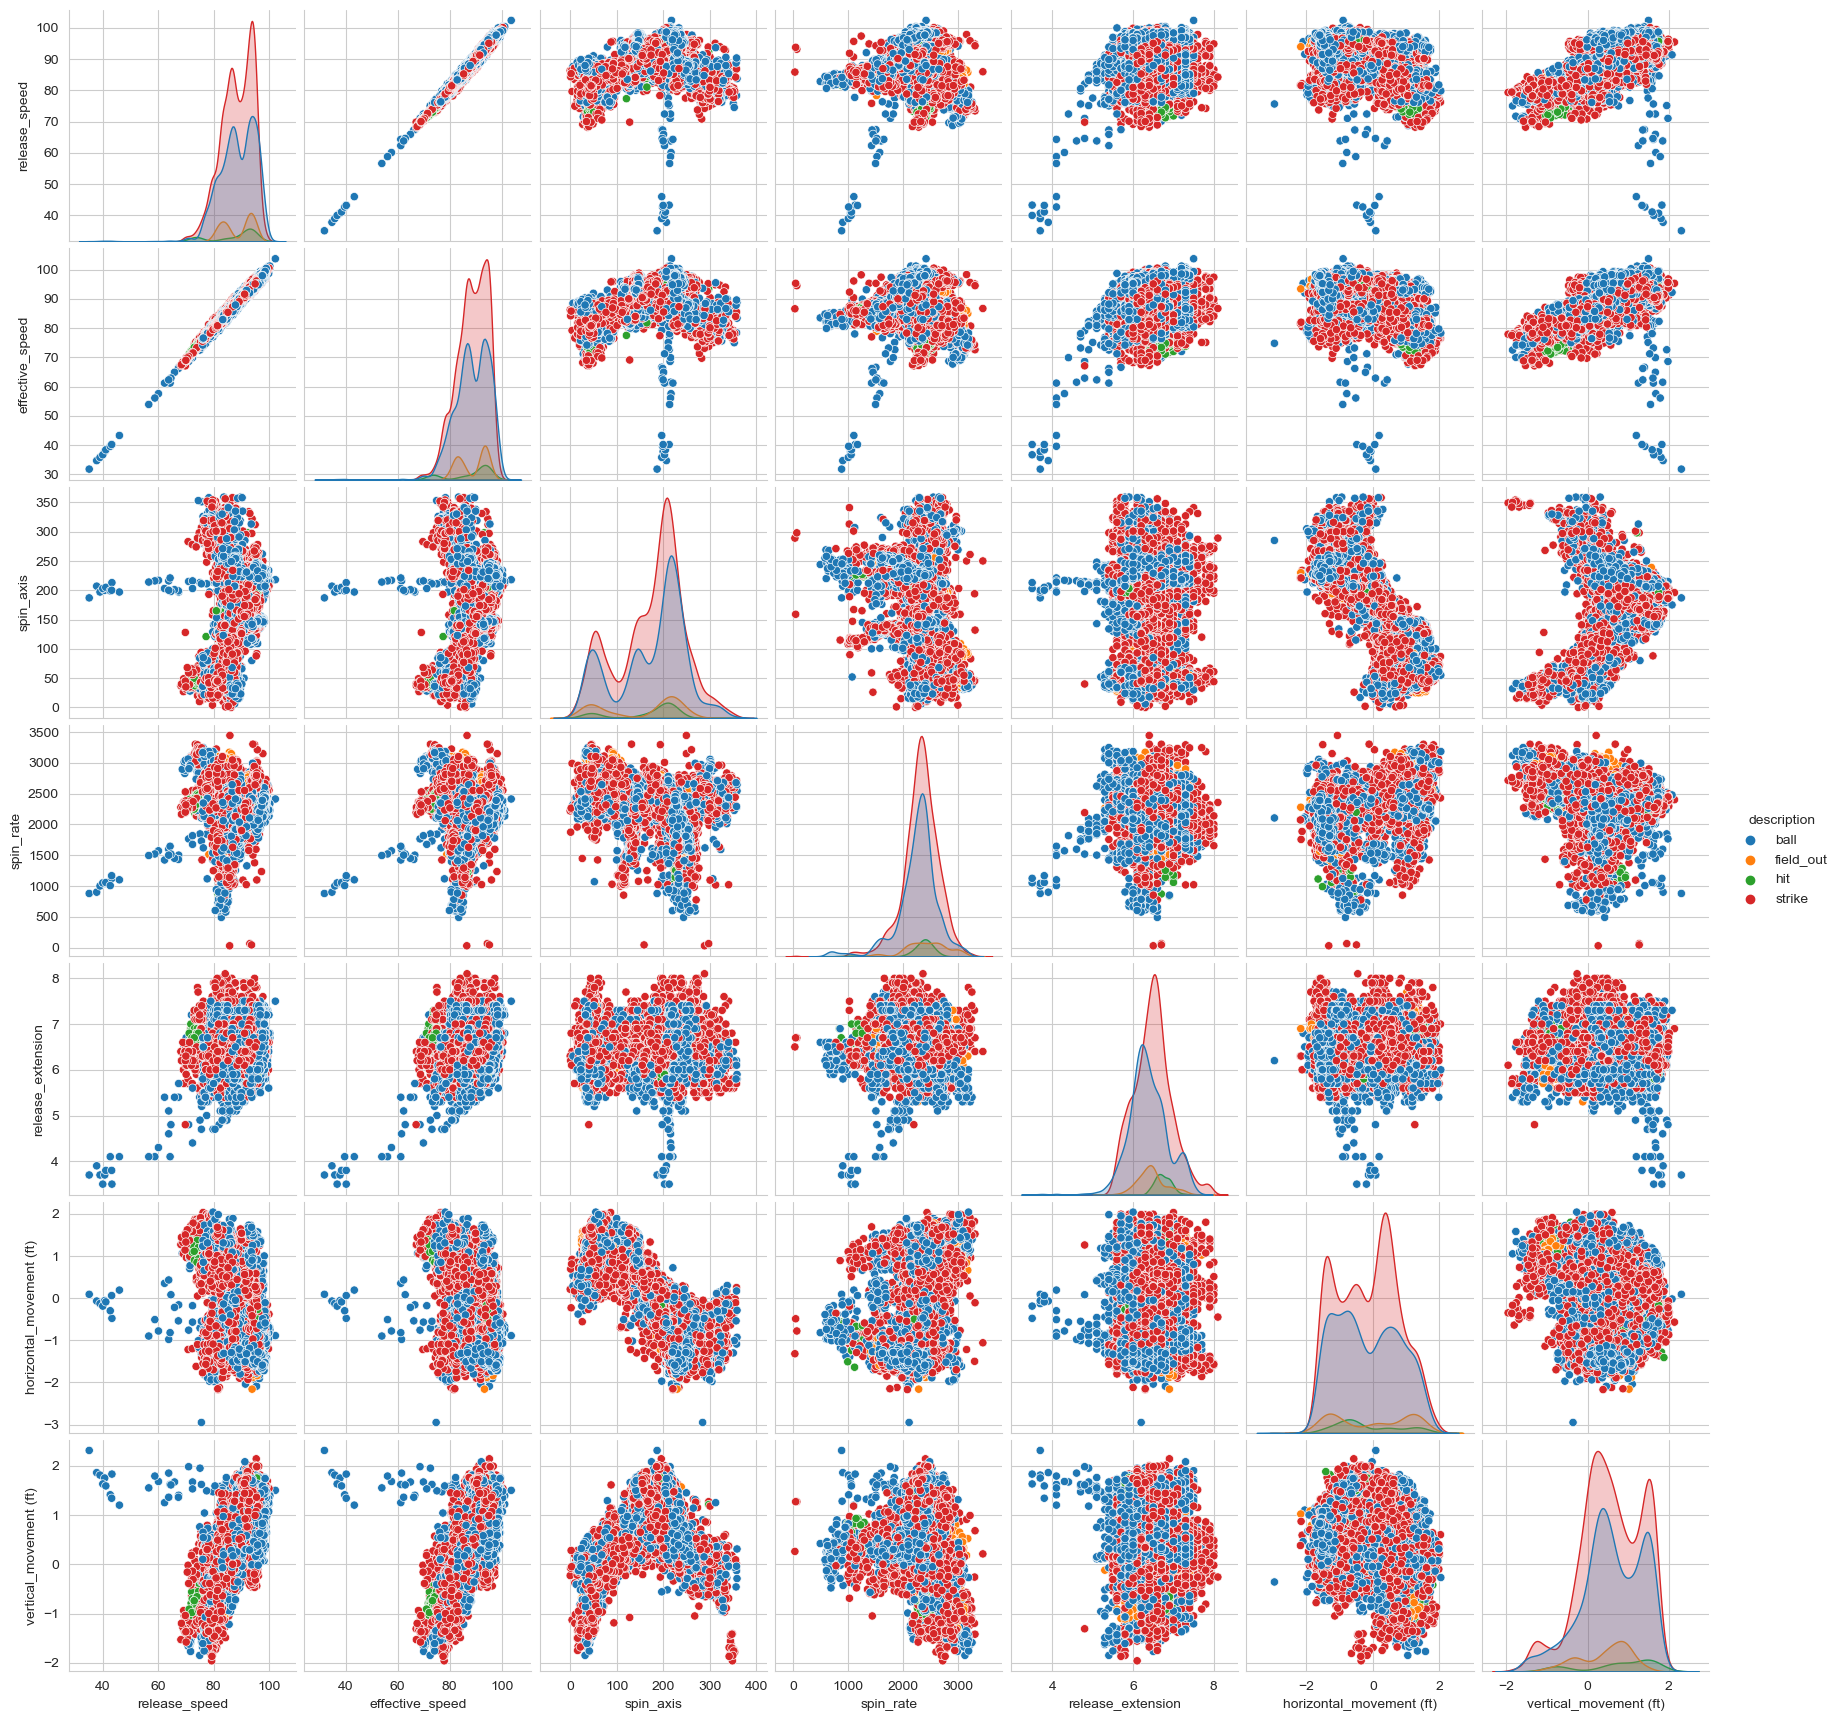

In [26]:
filtered_df2 = df_pitches_compact

# Pairplot of the filtered DataFrame
sns.pairplot(filtered_df2, hue='description')
plt.show()

Create chi-squared test for the pitch type and description

In [27]:
from scipy.stats import chi2_contingency

# Creating a contingency table for 'pitch_type' and 'description'
contingency_table = pd.crosstab(df_pitches_description['pitch_type'], df_pitches_description['description'])

# Performing the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

chi2, p, dof
print(f"Chi-squared: {chi2}")
print(f"p-value: {p}")
print(f"Degree of Freedom: {dof}")

Chi-squared: 2334.2043580792674
p-value: 0.0
Degree of Freedom: 36


In [28]:
contingency_table

description  ball  field_out  hit  strike
pitch_type                               
CH            396         37    0     686
CU            304          0   62     471
EP             10          0    0       0
FA             28          0    0       0
FC            397        103   32    1138
FF           1303         37  138    1552
FS            100          0   16     181
KC             97         41    0      18
PO              1          0    0       0
SI            736        200   39     890
SL            653         47   29     866
ST            337         49    0     468
SV              0        105    0      32

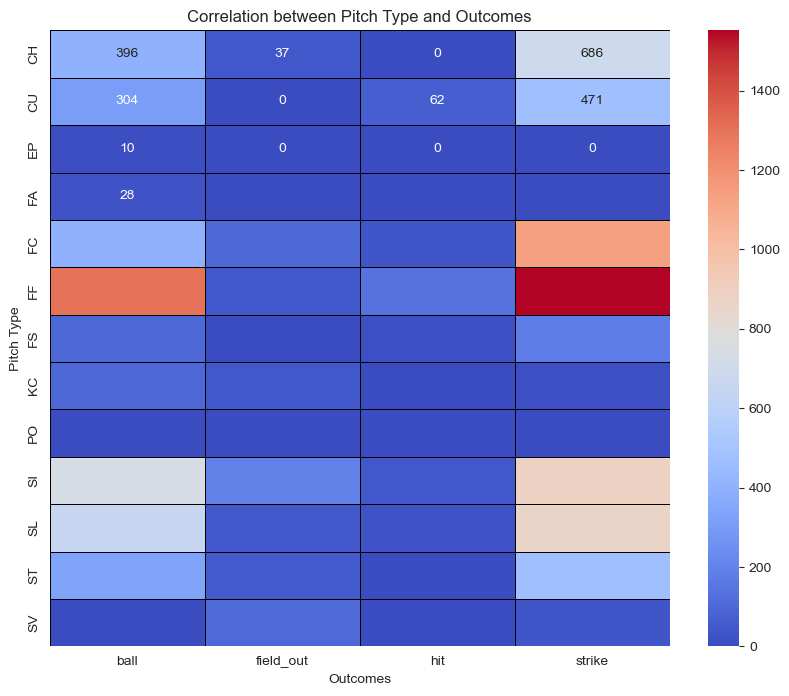

In [29]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt="d",\
     cmap="coolwarm", linewidths=0.5, linecolor='black')
plt.title('Correlation between Pitch Type and Outcomes')
plt.xlabel('Outcomes')
plt.ylabel('Pitch Type')
plt.show()

The p-value is effectively zero, which suggests that there is a statistically significant association between the type of pitch and the description of the pitch's outcome. This means that different types of pitches likely lead to different outcomes.

# Modeling Outcomes

We will be using neural networks and decision trees in the next phase to model our data. Both will be tested using cross-validation and the best parameters will be determined using grid search. The neural network will require the binarization of the description column, as there are 24 classes. This will be a classification task, as the models will be classifying which description class the predictor variables will result in.

# Project Aims

 Finally, what is your overarching aim with this project? What are you hoping to learn? Or, what 
hypothesis are using the data to confirm or disprove? What challenges do you foresee on this 
project? Discuss your concerns. How will you get your work done? Give a reasonable list of 
milestones to reach to arrive at the final deadline for the project.

Our overarching goal of this project is being able to predict what a pitch will result in (strike, ball, foul, hit on base) based on factors such as pitch speed, pitch axis, vertical/horizontal movement, and pitcher handedness. This model can then be used to predict which pitches will be best for a pitcher to throw by utilizing data such as the pitcher's average speed, axis, etc. for each type of pitch they throw.  Potential concerns is that these factors may not be comprehensive of the result such as the teams that were playing or the weather conditions of the game or physical condition of the pitcher/hitter, however, the results shown above in the EDA suggest at a minimum that there are certainly correlations between the pitch type and the result. 

## Milestones
* Create neural network with cross validation and grid search
* Create decision tree with CV and grid search
* Improve models to get >85% accuracy
* Use player data from other set (savant_data__1) to evaluate results of each pitch type for the particular pitcher based on their average metrics such as pitch speed for each pitch type, handedness, etc.